# Quantum Engine Engineered through DMBL Phase Cross-over

 Mahub Rahaman, Analabha Roy

# Introduction

### Level Statistics 


The transition of phases has been of utmost importance in science. In many body systems, the collective nature of systems always tends to equilibrate over extended periods. This can be prevented by attaining a non-equilibrium state by constraining the initial state of the system indefinitely. The ultra-cold ion trapping approach has proven feasible both theoretically and empirically over the past few decades. 

Indroducing a controlled disorder can be used to localize the initial state of the many-body system; therefore, it is called many-body localization (MBL). However, in a clean system, we can also "freeze" the initial state. This is done by applying an engineered periodic field. In previous works, for systems like the Ising model and the XYZ type model, a transverse preriodic field was applied, which resulted in the emergence of freezing by virtue of the dynamics of the system. Additionally, in our previous work, we established a many-body localization from dynamics in a clean system (DMBL) detected through theinverse participation ratio (IPR), which is the gerneal definition of a localization for a quantum system.

Studying the temporal variation of the corresponding order parameter of the system has been a common practice to investigate the phase transition. However, a more profound mathematical analysis is also adapted and implemented on a theoretical model. This is referred to as level statistics analysis. We will quickly outline the steps involved.

Step 1. Get the Floquet-quasienergies ($\epsilon_i$).

Step 2. Sort it ascending order according to Pedro Ponte.

Step 3. Take the adjuscent difference ($\delta_i = \epsilon_{i+1}- \epsilon_i$) between two quasienergies and store it for all quasienergies in an array.

Step 4. Find out min and max between two respective differences, such as min($\delta_{i+1. \delta_i}$) and max($\delta_{i+1. \delta_i}$).

Step 5. Get ratio between min and max and store it by $r_i = \frac{min}{max}$ for all possible $r_i$.

Step 6. Average $\langle r \rangle = \frac{1}{N}\sum_i^N r_i$.

ref:

[1] https://doi.org/10.1103/PhysRevB.99.024203 

[2] https://doi.org/10.1103/PhysRevLett.114.140401


## First, we shall check if the statistics follows GOE and POE from histogram plots

# TSS

In [33]:
%%time
from tqdm import tqdm
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve, Options, jmat
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
import matplotlib.pyplot as plt
from multiprocessing import Pool

def drive(t, args):
    h0, h, w = args['h0'], args['h'], args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_tss(N):
    sx,sy,sz = jmat(N,"x"), jmat(N,"y"), jmat(N,"z")
    kn =  2.0/(N-1)   
    H0 = kn * sx **2 
    H1 = 2 * sz
    return H0,H1,sx,sy,sz

def run_floquet_tss(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/64, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_ham_tss(N)
    T = 2 * np.pi/w
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies

if __name__ == '__main__':
    nprocs = 2
    opts = Options(nsteps=1e6)    
    
    N = 40
    ws = [0.5, 90.0]
        
    p = Pool(processes = nprocs)
    print("running for TSS spin=",N," with", nprocs," processors!")
    
    flq_tss = np.array(p.starmap(run_floquet_tss,[(w,N, opts) for w in ws]))

running for TSS spin= 40  with 2  processors!
CPU times: user 4.37 ms, sys: 28.6 ms, total: 33 ms
Wall time: 2.66 s


<timed exec>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


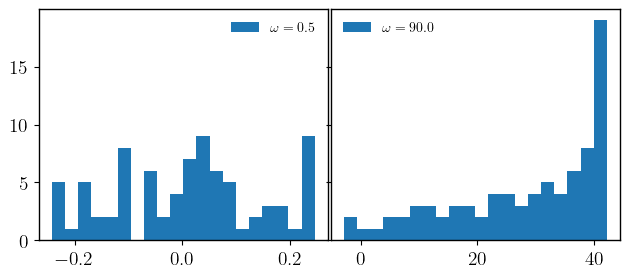

In [34]:
from matplotlib.gridspec import GridSpec
plt.rcParams.update({"figure.figsize": (7.5, 3),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Helvetica"], "axes.edgecolor": "black", "axes.linewidth": 1.0})


fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
plt.subplots_adjust(wspace=0.01)

for i in range(2):
    w = flq_tss[i][0]
    modes = np.array(flq_tss[i][1])[:,:,0]
    qe = np.array(flq_tss[i][2])
    axs[i].hist(qe, 20, label=fr'$\omega={w:1.1f}$')
    axs[i].legend(frameon = False, fontsize=10)    
plt.show()

#  Hilbert Space

In [37]:
%%time
from tqdm import tqdm
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve, Options, jmat
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
import matplotlib.pyplot as plt
from multiprocessing import Pool
from qutip import *

def drive(t, args):
    h0, h, w = args['h0'], args['h'], args['omega']
    return h0 + h * np.cos(w * t)

def get_hilbert_zzx(N):
    sigx = sigmax()
    sigy = sigmay()
    sigz = sigmaz()
    H0, H1, sx, sy, sz = [], [], [], [], []
    
    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.array((tensor(qeye(2**(i-0)),\
                          tensor(sigx,tensor(qeye(2**(j-i-1)),tensor(sigx,qeye(2**(N-1-j))))))).full())) 
    
    for i in range(N):
        sx.append(np.array((tensor(qeye(2**(i-0)),tensor(sigx,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sy.append(np.array((tensor(qeye(2**(i-0)),tensor(sigy,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sz.append(np.array((tensor(qeye(2**(i-0)),tensor(sigz,qeye(2**(N-1-i))))).full()))
            
    kacN = 2/(N-1)
    
    H0 = Qobj(kacN * np.sum(H0, axis =0))
    H1 = Qobj(np.sum(sz, axis =0))
    
    return H0, H1, sx, sy, sz

def run_floquet_hilbert(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/32, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_hilbert_zzx(N)
    T = 2 * np.pi/w
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies

if __name__ == '__main__':
    nprocs = 2
    opts = Options(nsteps=1e6)    
    
    N = 7
    ws = [0.5, 90.0]
        
    p = Pool(processes = nprocs)
    print("running for Hilbert space:",N," with", nprocs," processors!")
    
    flq_hilbert = np.array(p.starmap(run_floquet_hilbert,[(w,N, opts) for w in ws]))

running for Hilbert space: 7  with 2  processors!
CPU times: user 12.1 ms, sys: 24.4 ms, total: 36.5 ms
Wall time: 1.4 s


<timed exec>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


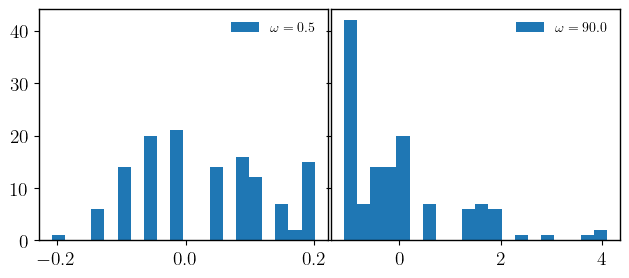

In [38]:
from matplotlib.gridspec import GridSpec
plt.rcParams.update({"figure.figsize": (7.5, 3),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 14,"font.sans-serif": ["Helvetica"], "axes.edgecolor": "black", "axes.linewidth": 1.0})


fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
plt.subplots_adjust(wspace=0.01)

for i in range(2):
    w = flq_hilbert[i][0]
    modes = np.array(flq_hilbert[i][1])[:,:,0]
    qe = np.array(flq_hilbert[i][2])
    axs[i].hist(qe, 20, label=fr'$\omega={w:1.1f}$')
    axs[i].legend(frameon = False, fontsize=10)    
plt.show()

# Plot them together TSS and Hilbert

In [41]:
%%time
from tqdm import tqdm
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve, Options, jmat
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
import matplotlib.pyplot as plt
from multiprocessing import Pool

def drive(t, args):
    h0, h, w = args['h0'], args['h'], args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_tss(N):
    sx,sy,sz = jmat(N,"x"), jmat(N,"y"), jmat(N,"z")
    kn =  2.0/(N-1)   
    H0 = kn * sx **2
    H1 = 2 * sz
    return H0,H1,sx,sy,sz

def get_hilbert_zzx(N):
    sigx = sigmax()
    sigy = sigmay()
    sigz = sigmaz()
    H0, H1, sx, sy, sz = [], [], [], [], []
    
    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.array((tensor(qeye(2**(i-0)),\
                          tensor(sigx,tensor(qeye(2**(j-i-1)),tensor(sigx,qeye(2**(N-1-j))))))).full())) 
    
    for i in range(N):
        sx.append(np.array((tensor(qeye(2**(i-0)),tensor(sigx,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sy.append(np.array((tensor(qeye(2**(i-0)),tensor(sigy,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sz.append(np.array((tensor(qeye(2**(i-0)),tensor(sigz,qeye(2**(N-1-i))))).full()))
            
    kacN = 2/(N-1)
    
    H0 = Qobj(kacN * np.sum(H0, axis =0))
    H1 = Qobj(np.sum(sz, axis =0))
    
    return H0, H1, sx, sy, sz


def run_floquet_tss(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/64, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_ham_tss(N)
    T = 2 * np.pi/w
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies, N

def run_floquet_hilbert(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/64, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_hilbert_zzx(N)
    T = 2 * np.pi/w
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies, N

if __name__ == '__main__':
    nprocs = 2
    opts = Options(nsteps=1e5)    
    
    size = 5
    
    # TSS
    #N = size * 2
    N = 30
    ws = [0.3, 90.0]
        
    p = Pool(processes = nprocs)
    print("running for TSS spin=",N," with", nprocs," processors!")
    
    flq_tss = np.array(p.starmap(run_floquet_tss,[(w,N, opts) for w in ws]))    
    #Hilbert
    N = size
    
    p = Pool(processes = nprocs)
    print("running for Hilbert spin=",N," with", nprocs," processors!")
    flq_hilbert = np.array(p.starmap(run_floquet_hilbert,[(w,N, opts) for w in ws]))

running for TSS spin= 30  with 2  processors!


<timed exec>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


running for Hilbert spin= 5  with 2  processors!
CPU times: user 5.39 ms, sys: 55.6 ms, total: 61 ms
Wall time: 2.03 s


<timed exec>:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


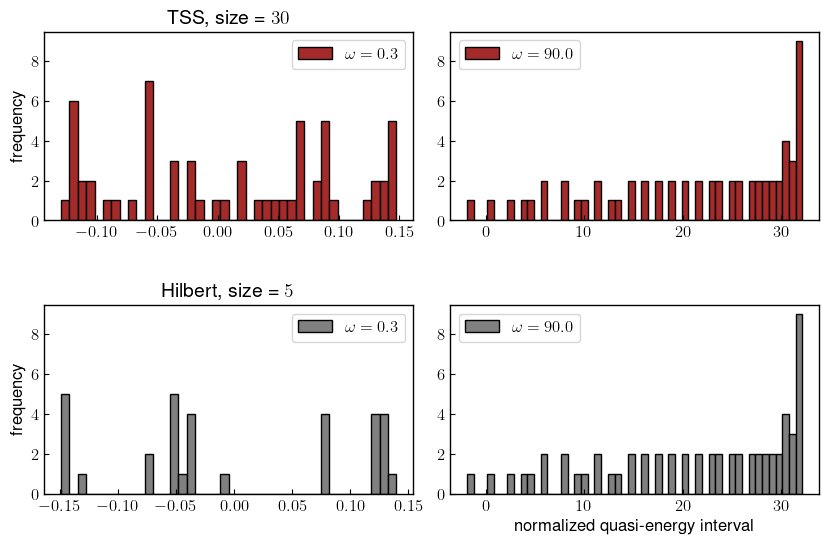

In [49]:
from matplotlib.gridspec import GridSpec
plt.rcParams.update({"figure.figsize": (10,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"], "axes.edgecolor": "black", "axes.linewidth": 1.0})


w = flq_tss[0][0]
modes = np.array(flq_tss[0][1])[:,:,0]
size = flq_tss[0][3]
qe =np.array(flq_tss[0][2])

ax1 = plt.subplot(2, 2, 1)
ax1.hist(qe, bins=bns[0], label=fr'$\omega={w:1.1f}$', color='brown',edgecolor='black')
ax1.tick_params(which='both', axis="y", direction="in")
ax1.tick_params(which='both', axis="x", direction="in")
ax1.legend()
ax1.set_ylabel(r"frequency")
ax1.set_title(fr'TSS, size = ${size}$', fontsize= 14)

w = flq_tss[1][0]
modes = np.array(flq_tss[1][1])[:,:,0]
size = flq_tss[1][3]
qe = np.array(flq_tss[1][2])

ax2 = plt.subplot(2, 2, 2,  sharey=ax1)
ax2.hist(qe, bins=bns[1], label=fr'$\omega={w:1.1f}$', color='brown',edgecolor='black')
ax2.tick_params(which='both', axis="y", direction="in")
ax2.tick_params(which='both', axis="x", direction="in")
ax2.legend()

w = flq_hilbert[0][0]
modes = np.array(flq_hilbert[0][1])[:,:,0]
size = flq_hilbert[0][3]
qe1 = np.array(flq_hilbert[0][2])

ax3 = plt.subplot(2, 2, 3)
ax3.hist(qe1, bins=bns[0], label=fr'$\omega={w:1.1f}$', color='grey',edgecolor='black')
ax3.tick_params(which='both', axis="y", direction="in")
ax3.tick_params(which='both', axis="x", direction="in")
ax3.legend()
ax3.set_ylabel(r"frequency")
ax3.set_title(fr'Hilbert, size = ${size}$', fontsize= 14)

w = flq_tss[1][0]
modes = np.array(flq_tss[1][1])[:,:,0]
size = flq_tss[1][3]
qe1 = np.array(flq_tss[1][2])

ax4 = plt.subplot(2, 2, 4,  sharey=ax3)
ax4.hist(qe1, bins=bns[1], label=fr'$\omega={w:1.1f}$', color='grey',edgecolor='black')
ax4.tick_params(which='both', axis="y", direction="in")
ax4.tick_params(which='both', axis="x", direction="in")
ax4.legend()
ax4.set_xlabel(r"normalized quasi-energy interval")

plt.subplots_adjust(wspace=0.1, hspace=0.45)

# Investigate LSR for Phase transtion

In [3]:
%%time
from tqdm import tqdm
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve, Options, jmat, Qobj
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
import matplotlib.pyplot as plt
from multiprocessing import Pool

def drive(t, args):
    h0, h, w = args['h0'], args['h'], args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_tss(N):
    sx, sy, sz = jmat(N,"x"), jmat(N,"y"), jmat(N,"z")
    kn =  2.0/(N-1)   
    H0 = kn * sx **2 
    H1 = sz * 2
    return H0, H1, sx, sy, sz

def get_hilbert_xxz(N):
    sigx = sigmax()
    sigy = sigmay()
    sigz = sigmaz()
    H0, H1, sx, sy, sz = [], [], [], [], []
    
    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.array((tensor(qeye(2**(i-0)),\
                          tensor(sigx,tensor(qeye(2**(j-i-1)),tensor(sigx,qeye(2**(N-1-j))))))).full())) 
    
    for i in range(N):
        sx.append(np.array((tensor(qeye(2**(i-0)),tensor(sigx,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sy.append(np.array((tensor(qeye(2**(i-0)),tensor(sigy,qeye(2**(N-1-i))))).full()))
        
    for i in range(N):
        sz.append(np.array((tensor(qeye(2**(i-0)),tensor(sigz,qeye(2**(N-1-i))))).full()))
            
    kacN = 2/(N-1)
    H0 = Qobj(kacN * np.sum(H0, axis = 0))
    H1 = Qobj(np.sum(sz, axis =0)) 
    return H0, H1, sx, sy, sz

def run_floquet_tss(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/64, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_ham_tss(N)
    T = 2 * np.pi/w
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies, n_t

def run_floquet_hilbert(w,N, opts):    
    freezing_pts = jn_zeros(0,5)
    h = w/4 * freezing_pts[0]
    params = {'h0':np.pi/64, 'h':h, 'omega':w, 'opts':opts}
    
    H0, H1, Sx, Sy, Sz = get_hilbert_xxz(N)
    T = 2 * np.pi/w
    
    H = [H0,[H1,drive]]
    f_modes_0, f_energies = floquet_modes(H, T, params, options=opts)
    return w, f_modes_0, f_energies, n_h

if __name__ == '__main__':
    nprocs = 8
    opts = Options(nsteps=1e5)  
    p = Pool(processes = nprocs)    
    
    ws = np.linspace(2, 70, 30)           
    n_t,  n_h = 10, 3
    
    # TSS
    N = n_t
    print("running for TSS spin=",N," with", nprocs," processors!")
    flq_tss = np.array(p.starmap(run_floquet_tss,[(w,N, opts) for w in ws]))    
    
    #Hilbert
    N = n_h
    print("running for Hilbert spin=",N," with", nprocs," processors!")
    flq_hilbert = np.array(p.starmap(run_floquet_hilbert,[(w,N, opts) for w in ws]))

running for TSS spin= 10  with 8  processors!
running for Hilbert spin= 3  with 8  processors!
CPU times: user 129 ms, sys: 81.3 ms, total: 210 ms
Wall time: 618 ms


<timed exec>:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<timed exec>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


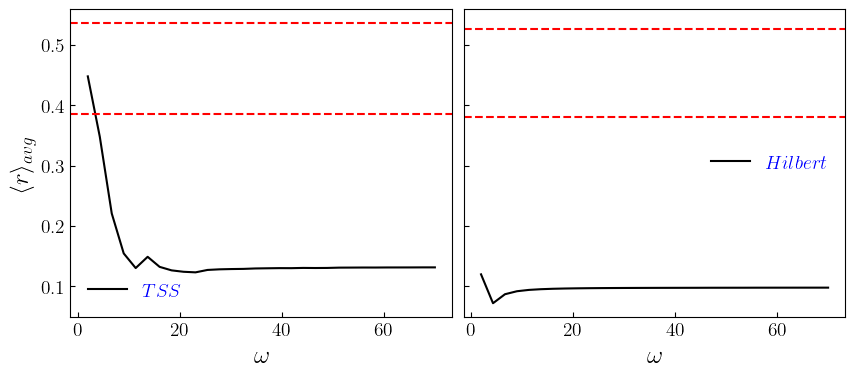

CPU times: user 247 ms, sys: 3.42 ms, total: 250 ms
Wall time: 258 ms


In [8]:
%%time

##############     BOTH TSS & HILBERT     ##################

# TRY TO PLOT QUASIERNGY W.R.T. number of QUASIMODES

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import pandas as pd

def convert_to_float_with_decimal_points(arr, n):
    result = []
    for item in arr:
        # Using the round() function to round to n decimal points
        rounded_float = round(item, n)
        result.append(rounded_float)
    return np.array(result)

lgndfnt = 10        # Legend font size
fnt = 14            # Global font size

plt.rcParams.update({"figure.figsize": (10.0, 4.0),
                     "text.usetex": True,
                     "font.family": "sans-serif",
                     "font.size": fnt,
                     "font.sans-serif": ["Computer Modern"]})

fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
plt.subplots_adjust(wspace=0.03)


rs = []
for i in range(0,len(ws)):
    w = flq_tss[i][0]
    modes = np.array(flq_tss[i][1])[:,:,0]
    size = flq_tss[i][3]
    qes = np.array(flq_tss[i][2])
    
    lvl = np.diff(np.sort(qes))
    
    rs.append(np.average(np.array([(min(lvl[j+1],\
                                        lvl[j])/max(lvl[j+1],lvl[j]))\
                                   for j in range(int(len(lvl)-1))])))
    
axs[0].plot(ws, rs, color = 'black', linewidth = 1.5, label = r"$TSS$") 
axs[0].set_xlabel(r"$\omega$", fontsize=18)
axs[0].set_ylabel(r"$\langle r \rangle _{avg}$", fontsize=18)
axs[0].axhline(y=.536, linestyle = '--', color = 'red')
axs[0].axhline(y=.386, linestyle = '--', color = 'red')
axs[0].tick_params(which='both',axis="x", direction="in")
axs[0].tick_params(which='both',axis="y", direction="in")
axs[0].legend(frameon = False, labelcolor = r"blue")


rs = []
for i in range(0,len(ws)):    
    w = flq_hilbert[i][0]
    modes = np.array(flq_hilbert[i][1])[:,:,0]
    qes = np.array(flq_hilbert[i][2])
    size = flq_hilbert[i][3]
    
    lvl = np.diff(np.sort(qes))  
    r = []
    
    for j in range(int(len(lvl)-1)):
        mn = min(lvl[j+1],lvl[j])
        mx = max(lvl[j+1],lvl[j])
        r.append(mn/mx)
    rs.append(np.average(np.array(r)))
    
axs[1].plot(ws, rs, color = 'black', linewidth = 1.5, label= r"$Hilbert$") 
axs[1].set_xlabel(r"$\omega$", fontsize=18)
axs[1].axhline(y=.527, linestyle = '--', color = 'red')
axs[1].axhline(y=.38, linestyle = '--', color = 'red')
axs[1].tick_params(which='both',axis="x", direction="in")
axs[1].tick_params(which='both',axis="y", direction="in")
axs[1].legend(frameon = False, labelcolor = 'blue')

#figname = "lvl_stat" + str(n_t) + "_tss.jpeg"
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi = 600)

plt.show()